In [1]:
import numpy as np
from tifffile import imread
import caiman as cm
from caiman.motion_correction import MotionCorrect

# Padding functions
def pad_array_center(input_array, output_shape, constant_values, mode):
    input_shape = input_array.shape
    pad_width = [(0, 0)] * len(input_shape)
    
    for i in range(len(input_shape)):
        total_pad = output_shape[i] - input_shape[i]
        pad_before = total_pad // 2
        pad_after = total_pad - pad_before
        pad_width[i] = (pad_before, pad_after)
    
    if mode == 'constant':
        padded_array = np.pad(input_array, pad_width, mode='constant', constant_values=constant_values)
    elif mode == 'median':
        median_value = np.median(input_array)
        padded_array = np.pad(input_array, pad_width, mode='constant', constant_values=median_value)
    elif mode == 'low_30_percent':
        low_30_percent_value = np.percentile(input_array, 30)
        padded_array = np.pad(input_array, pad_width, mode='constant', constant_values=low_30_percent_value)
    else:
        raise ValueError("Invalid mode. Choose from 'constant', 'median', or 'low_30_percent'.")
    return padded_array

def pad_movie(movie, output_shape, constant_values, mode):
    return np.array(list(map(lambda arr: pad_array_center(arr, output_shape, constant_values, mode), movie)))

# Main CaImAn registration function with padding
def CaImAnRegistration(fname, output_path_caiman, output_shape=None, mode = 'constant' ,constant_values=0):
    try:
        cv2.setNumThreads(0)
    except:
        pass

    # Load the movie data
    data = imread(fname)  # TODO: Add logic for h5 as well

    # Determine output shape for padding if not provided
    if output_shape is None:
        output_shape = tuple(dim + 60 for dim in data.shape[1:]) #data.shape[1:]  # Use existing frame dimensions if no output shape is specified

    # Pad the movie frames to the desired shape
    padded_data = pad_movie(data, output_shape, constant_values, mode)

    max_shifts = (50, 50)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
    strides = (48, 48)     # create a new patch every x pixels for pw-rigid correction
    overlaps = (24, 24)    # overlap between patches (size of patch strides+overlaps)
    max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
    pw_rigid = False       # flag for performing rigid or piecewise rigid motion correction
    shifts_opencv = False  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
    border_nan = 'copy'    # replicate values along the boundary (if True, fill in with NaN)

    # Start the cluster (if a cluster already exists terminate it)
    if 'dview' in locals():
        cm.stop_server(dview=dview)
    
    c, dview, n_processes = cm.cluster.setup_cluster(
        backend='multiprocessing', n_processes=None, single_thread=False)

    # Create a motion correction object using padded data
    mc = MotionCorrect(padded_data, dview=dview, max_shifts=max_shifts,
                       shifts_opencv=shifts_opencv, nonneg_movie=True,
                       border_nan=border_nan)

    # Perform motion correction
    mc.motion_correct(save_movie=True)
    
    # Load corrected movie and save it to disk
    # m_rig = cm.load(mc.mmap_file)
    # m_rig.save(output_path_caiman)

    # Get and center shifts around zero
    coordinates = mc.shifts_rig
    x_shifts = [coord[0] for coord in coordinates]
    y_shifts = [coord[1] for coord in coordinates]

    # x_shifts_mean = np.mean(x_shifts)
    # y_shifts_mean = np.mean(y_shifts)

    return x_shifts , y_shifts 

In [2]:
x, y = CaImAnRegistration('/root/capsule/data/iGluSnFR_simulations/1/SIMULATION_scan_00001_1_Trial1.tif', '/root/capsule/results/test.tif', output_shape=None, mode = 'median',constant_values=np.NaN) #TODO: Pad with the median of the movie or Nans or 30% percentile of movie.

In [20]:
import h5py

# Create an HDF5 file and save the NumPy array
with h5py.File('/root/capsule/results/x.h5', 'w') as hdf:
    hdf.create_dataset('x', data=x)

In [21]:
with h5py.File('/root/capsule/results/x.h5', 'r') as hdf:
    loaded_array = hdf['x'][:]
    print(loaded_array)

[0.1 0.1 0.1 ... 0.1 0.1 0.1]


In [6]:
x

[0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 0.1,
 -0.0,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 0.1,
 0.1,
 -0.0,
 -0.0,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.

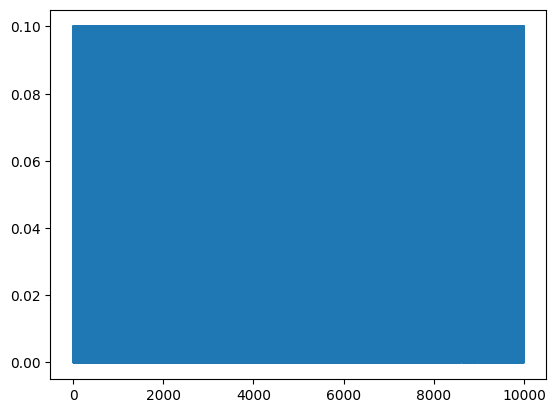

In [5]:
import matplotlib.pyplot as plt
plt.plot(x)

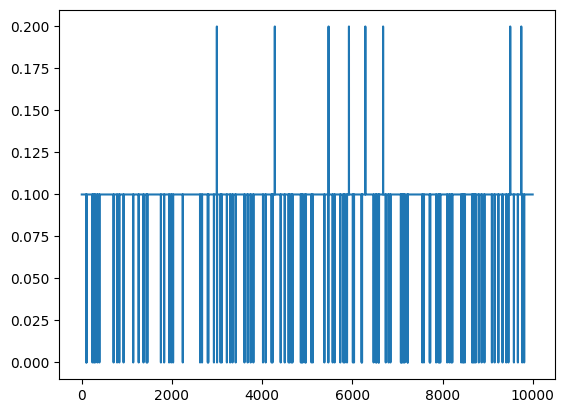

In [23]:
plt.plot(x)

In [29]:
data = imread('/root/capsule/data/iGluSnFR_simulations/1/SIMULATION_scan_00001_1_Trial1.tif') 
output_shape = [95, 175] #data.shape[1:]  # Use existing frame dimensions if no output shape is specified
padded_data = pad_movie(data, output_shape, constant_values=np.NaN)

In [36]:
tuple(dim + 50 for dim in data.shape[1:])

(95, 175)

In [25]:
padded_data.shape, data.shape

((10000, 95, 175), (10000, 45, 125))

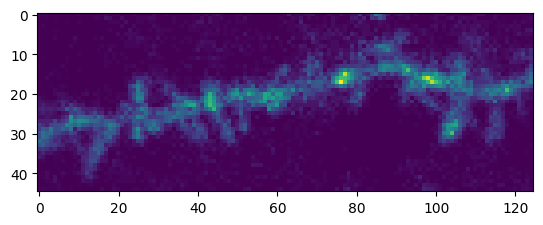

In [26]:
import matplotlib.pyplot as plt

plt.imshow(data[1,:, :])

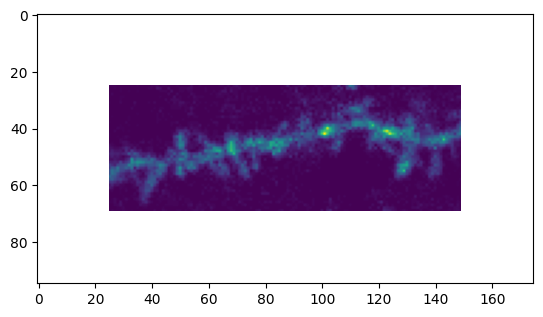

In [30]:
import matplotlib.pyplot as plt

plt.imshow(padded_data[1,:, :])

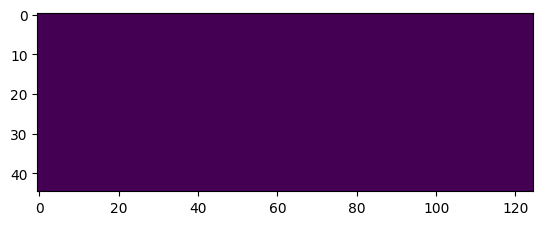

In [11]:
plt.imshow(padded_data[1,:, :]-data[1,:, :])